# Comparison of northern boundary forcing options against TPXO
Even though we know now, that they destrock our ACC

In [22]:
# load roms history output as Xarray dataset
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np

First set up bunch of functions from tides-tuning notebook

In [23]:
import ttide as tt
import numpy as np
import pandas as pd
from scipy.interpolate import NearestNDInterpolator
import sys
import os

# add the 'src/visualization/' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)

# import my methods, make sure they get reloded by each call
from visualization.log_progress import log_progress

def NDinterp(data):

    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = NearestNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled    


def O1_M2_ampl(ds,grid_ds,res):
    
    print('setting up the new fields')
    dummy = np.empty((ds.eta_rho.size,ds.xi_rho.size))
    dummy[:,:] = np.nan
    
    ds['O1_ampl']=(('eta_rho','xi_rho'),dummy.copy())
    ds['M2_ampl']=(('eta_rho','xi_rho'),dummy.copy())
    ds['O1_phase']=(('eta_rho','xi_rho'),dummy.copy())
    ds['M2_phase']=(('eta_rho','xi_rho'),dummy.copy())
    
    stime = pd.to_datetime(ds.ocean_time[0].values)
     
    print("applying t_tide")
    xi_values = np.linspace(0,ds.xi_rho.size-1,res,dtype=int,endpoint=True)
    eta_values = np.linspace(0,ds.eta_rho.size-1,res,dtype=int,endpoint=True)
    
    for xi in log_progress(xi_values,name='xi'):
        
        for eta in eta_values:
            ds_sl = ds.isel(eta_rho=eta,xi_rho=xi)

            if ds_sl.zeta.isnull().values.any():
                ds.O1_ampl[eta,xi] = np.NaN
                ds.M2_ampl[eta,xi] = np.NaN
                ds.O1_phase[eta,xi] = np.NaN
                ds.M2_phase[eta,xi] = np.NaN
                
            else:
                signal = ds_sl.zeta.values
                latitude = ds_sl.lat_rho.values
                try:
                    ttide_out = tt.t_tide(signal,stime=stime,lat=latitude,out_style=None)

                    ind_O1 = list(ttide_out['nameu']).index(b'O1  ')
                    ind_M2 = list(ttide_out['nameu']).index(b'M2  ')

                    ds.O1_ampl[eta,xi] = ttide_out['tidecon'][ind_O1][0]
                    ds.O1_phase[eta,xi] = ttide_out['tidecon'][ind_O1][2]
                    
                    ds.M2_ampl[eta,xi] = ttide_out['tidecon'][ind_M2][0]
                    ds.M2_phase[eta,xi] = ttide_out['tidecon'][ind_M2][2]

                except TypeError:
                    ds.O1_ampl[eta,xi] = np.NaN
                    ds.O1_phase[eta,xi] = np.NaN
                    ds.M2_ampl[eta,xi] = np.NaN
                    ds.M2_phase[eta,xi] = np.NaN
                    
    print('interpolating the remaining cells and mask land')
    for con in ['O1_ampl','M2_ampl','O1_phase','M2_phase']:
        ds[con].values = NDinterp(ds[con].values)
        ds[con] = ds[con].where(grid_ds.mask_rho,0.0) 
      
        
    return ds

In [24]:
def plot_max_ampl(case_max_ampl_da,case_str,ref_max_ampl,ref_str):
    plt.clf()
    fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
    fig.suptitle('Comparison of maximum tidal height amplitude ROMS vs. TPXO7.2',fontsize=16)
    ref_max_ampl.fillna(0).plot(ax=ax1,vmax=4)
    ax1.set_title(ref_str+' [m]')
    ax1.axis('off')
    
    case_max_ampl_da.fillna(0).plot(ax=ax2,vmax=4)
    ax2.set_title(case_str+ ' [m]')
    ax2.axis('off')
    tpxo_ampl_max.tide_Eamp.plot(ax=ax3,vmax=4)
    ax3.set_title('TPXO (theoretical)')
    ax3.axis('off')
    plt.show()

In [25]:
# load tpxo forcing amplitude and phase information as Xarray dataset
def plot_M2O1(case_ds,case_str,ds_ref,ref_str):
    plt.close('all')
    fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(17,8))
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()
    fig.suptitle('Comparison of M2 and O1 height amplitude',fontsize=16)

    ds_ref.M2_ampl.fillna(0).plot(ax=ax1,vmax=1.5)
    ax1.set_title(ref_str+' [m]')
    ax1.axis('off')

    case_ds.M2_ampl.fillna(0).plot(ax=ax2,vmax=1.5)
    ax2.set_title(case_str +' [m]')
    ax2.axis('off')

    dsf.tide_Eamp[0].plot(ax=ax3,vmax=1.5)
    ax3.set_title('TPXO M2 amplitude in m')
    ax3.axis('off')


    ds_ref.O1_ampl.fillna(0).plot(ax=ax4,vmax=0.5)
    ax4.set_title(ref_str+' [m]')
    ax4.axis('off')

    case_ds.O1_ampl.fillna(0).plot(ax=ax5,vmax=0.5)
    ax5.set_title(case_str+' [m]')
    ax5.axis('off')

    dsf.tide_Eamp[5].plot(ax=ax6,vmax=1.5)
    ax6.set_title('TPXO O1 amplitude in m')
    ax6.axis('off')

    plt.show()

In [26]:
# load tpxo forcing amplitude and phase information as Xarray dataset
tpxo_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_tds_large.nc')
dsf = xr.open_mfdataset(tpxo_path)

# calculate the superposition of amplitudes of all constituents (max tidal amplitude possible)
tpxo_ampl_max = dsf.sum('tide_period')

## Max tidal height amplitude SSH and UV alone

In [27]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_SSH','ocean_his_0006.nc')
ds_SSH = xr.open_mfdataset(file_path,chunks={'xi_rho':10,'eta_rho':10})

# calculate maximum anomaly of the free surface height compared to the 14 day mean
%time SSH_maxAmpl = ds_SSH.zeta[336:].max('ocean_time')-ds_SSH.zeta[336:].mean('ocean_time')

CPU times: user 47.1 s, sys: 9.9 s, total: 57 s
Wall time: 54.4 s


In [28]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_UV','ocean_his_0002.nc')
ds_UV = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
%time UV_maxAmpl = ds_UV.zeta[336:].max('ocean_time')-ds_UV.zeta[336:].mean('ocean_time')

CPU times: user 37.9 ms, sys: 35.2 ms, total: 73.1 ms
Wall time: 66 ms


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


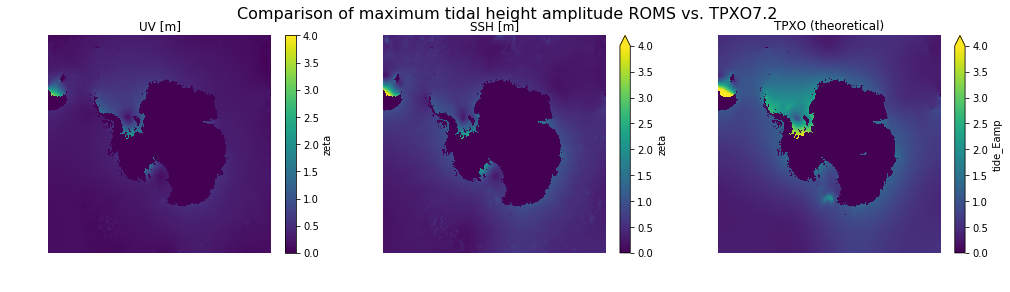

In [29]:
plot_max_ampl(SSH_maxAmpl,'SSH',UV_maxAmpl,'UV')

## O1 and M2 amplitudes UV and SSH alone

In [30]:
ds_SSH = O1_M2_ampl(ds_SSH,ds_SSH,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


In [31]:
ds_UV = O1_M2_ampl(ds_UV,ds_UV,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


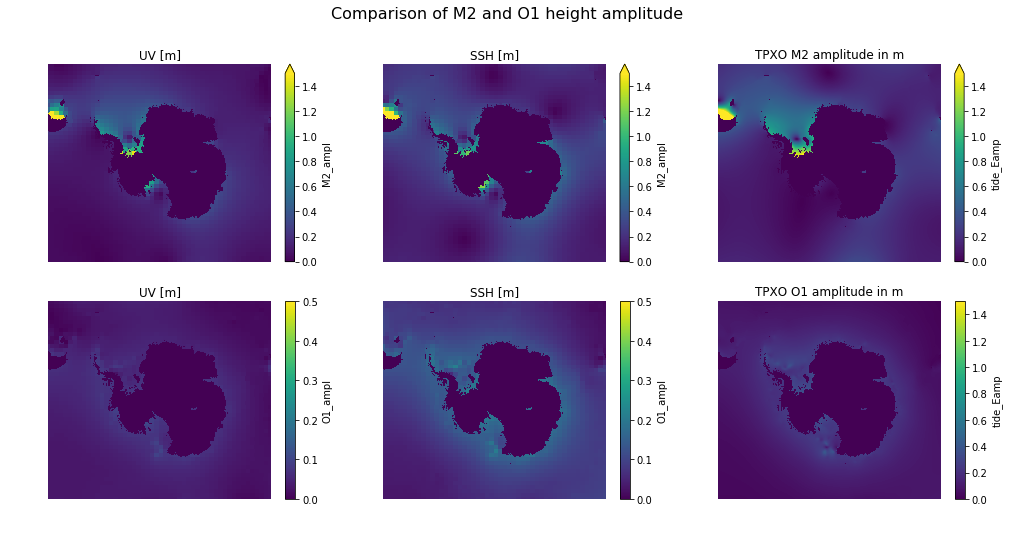

In [32]:
plot_M2O1(ds_SSH,'SSH',ds_UV,'UV')

## Max height amplitude SSHUV and SSHUVPOT

In [33]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_SSHUV','ocean_his_0002.nc')
ds_SSHUV = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
SSHUV_maxAmpl = ds_SSHUV.zeta[336:].max('ocean_time')-ds_SSHUV.zeta[336:].mean('ocean_time')

In [34]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_SSHUVPOT','ocean_his_0002.nc')
ds_SSHUVPOT = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
SSHUVPOT_maxAmpl = ds_SSHUVPOT.zeta[336:].max('ocean_time')-ds_SSHUVPOT.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


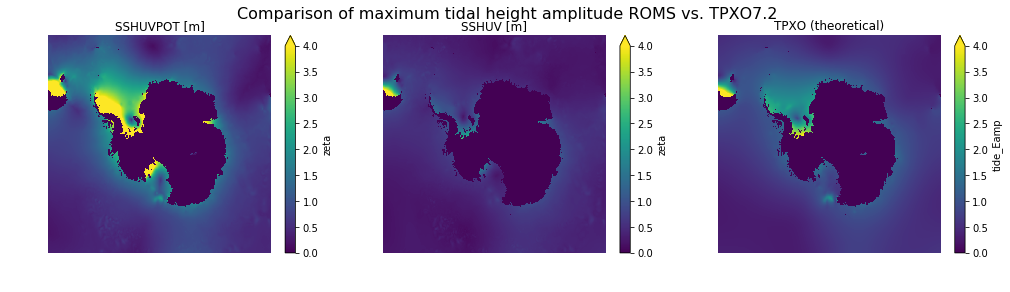

In [35]:
plot_max_ampl(SSHUV_maxAmpl,'SSHUV',SSHUVPOT_maxAmpl,'SSHUVPOT')

## M2 and O1 amplitudes SSHUV and SSHUVPOT

In [36]:
ds_SSHUV = O1_M2_ampl(ds_SSHUV,ds_SSHUV,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


In [37]:
ds_SSHUVPOT = O1_M2_ampl(ds_SSHUVPOT,ds_SSHUVPOT,50)

setting up the new fields
applying t_tide


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating the remaining cells and mask land


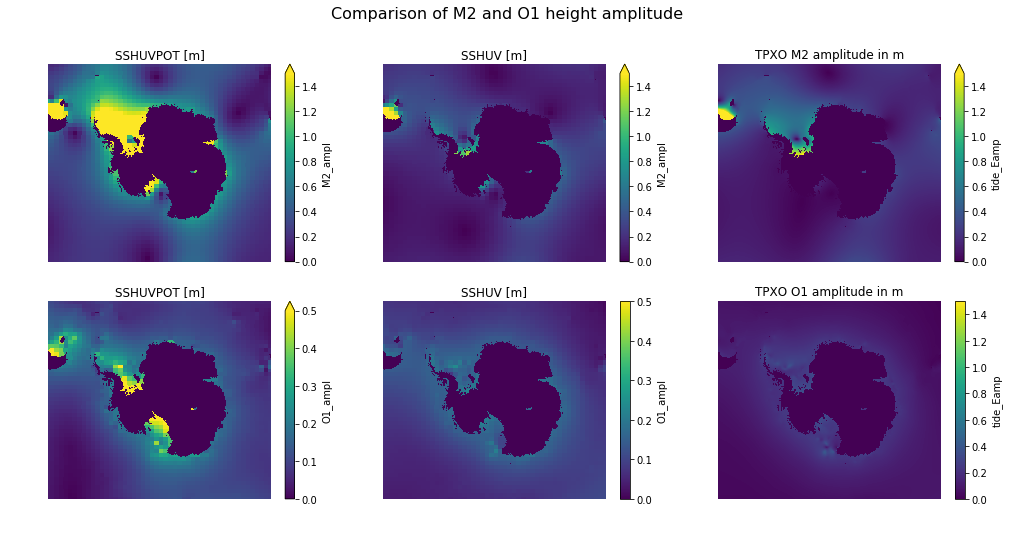

In [38]:
plot_M2O1(ds_SSHUV,'SSHUV',ds_SSHUVPOT,'SSHUVPOT')

## Large scale circulation of all cases

In [39]:
import xarray as xr
import os
import sys

src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)
from visualization.plot_barotropic_xr import plot_avg_uvbar_ssh


# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1
%aimport visualization.plot_barotropic_xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


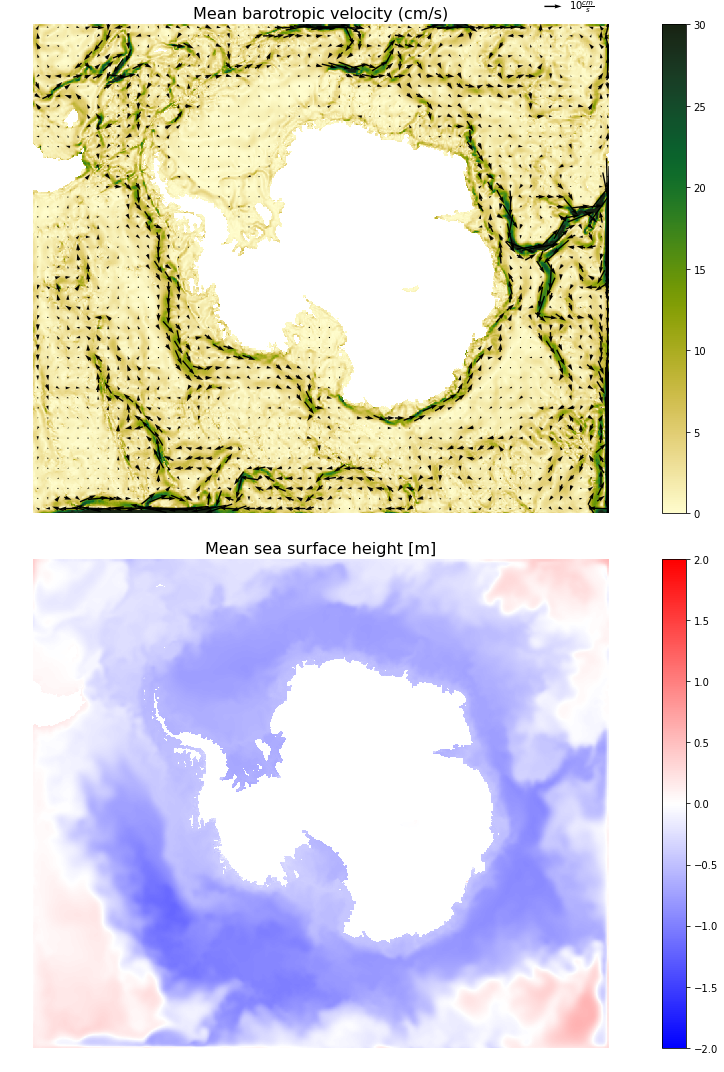

In [40]:
file_path = os.path.join(os.environ.get('rawdir'),'waom10_SSHUV','ocean_avg_uv_0002.nc')
ds_SSHUV_uv = xr.open_mfdataset(file_path)
plot_avg_uvbar_ssh(ds_SSHUV_uv.mean('ocean_time'))